In [1]:
import numpy as np
import os
import cv2
import random
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
from shutil import copy
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data_path = 'C:/Users/...'

def data_preparation(data_path, valid_data=0.1, test_data=0.05):
    folders = os.listdir(data_path)
    training_path = data_path + '/train'
    ttv = ['test', 'train', 'valid']
    train_data = 1 - valid_data - test_data
    if train_data < 0 or train_data > 1 :
        raise ValueError('The parameter valid_data must be between 0 and 1')
        
    if not os.path.exists(training_path):
        os.mkdir('train')
        os.mkdir('test')
        os.mkdir('valid')
        
    elif os.listdir(train_path) == []:
        
        for folder in (set(folders) - set(ttv)): # Überordner mit gespeicherten Bildern
            folder_content = os.listdir(folder)
            len_content = len(folder_content)
            num_train = round(len_content * train_data) # percentage of training data
            num_test = round(len_content * test_data)
            for name in ttv:
                sub_folder = '/'.join([data_path, name, folder]) # Kreiere Unterordner mit gleichem Namen wie Überordner in ttv Ordnern
                if not os.path.exists(sub_folder):
                    os.mkdir(sub_folder)
                if name == 'train':
                    for file in folder_content[:num_train]:
                        file = '/'.join([folder,file])
                        copy(file, sub_folder)
                elif name == 'valid':
                    for file in folder_content[num_train:-num_test]:
                        file = '/'.join([folder,file])
                        copy(file, sub_folder)
                elif name == 'test':
                    for file in folder_content[-num_test:]:
                        file = '/'.join([folder,file])
                        copy(file, sub_folder)

                        
#data_preparation(data_path)


In [3]:
train_path = 'C:/Users/.../train'
valid_path = 'C:/Users/.../valid'
test_path = 'C:/Users/.../test'

In [4]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True
)

test_datagen = ImageDataGenerator(#rescale=1./255
                                 )

In [16]:
IMG_SIZE = 224
CATEGORIES = ['Cat', 'Dog']
batch_size = 64

train_batches = train_datagen.flow_from_directory(
        train_path, 
        target_size=(IMG_SIZE,IMG_SIZE),
        classes=CATEGORIES, 
        batch_size=batch_size)

valid_batches = train_datagen.flow_from_directory(
        valid_path, 
        target_size=(IMG_SIZE,IMG_SIZE), 
        classes=CATEGORIES, 
        batch_size=batch_size)

test_batches = test_datagen.flow_from_directory(
        test_path, 
        target_size=(IMG_SIZE,IMG_SIZE),
        classes=CATEGORIES,
        batch_size=batch_size)


Found 1117 images belonging to 2 classes.
Found 132 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


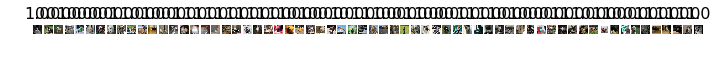

In [17]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3:
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims)%2 == 0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
        
train_imgs, train_labels = next(train_batches)
train_labels = train_labels[:,0]
plots(train_imgs, titles=train_labels)

In [18]:
vgg16_model = keras.applications.vgg16.VGG16()
#vgg16_model.summary()

In [19]:
model = Sequential()

for layer in vgg16_model.layers[:-1]: # Alle layer übertragen außer der letzten
    model.add(layer)

for layer in model.layers: # Bestehende Parameter einfrieren
    layer.trainable = False
    
#model.summary()

In [20]:
model.add(Dense(2, activation='softmax'))
#model.summary()

In [21]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
        train_batches,
        steps_per_epoch=round(1117/batch_size),
        validation_data=valid_batches, 
        validation_steps=round(132/batch_size), 
        epochs=5, 
        verbose=1)

Epoch 1/5
17/17 [==============================] - 1231s 72s/step - loss: 1.1022 - acc: 0.5719 - val_loss: 0.7247 - val_acc: 0.6562
Epoch 2/5
17/17 [==============================] - 1029s 61s/step - loss: 0.6523 - acc: 0.7169 - val_loss: 0.5338 - val_acc: 0.7206
Epoch 3/5
17/17 [==============================] - 968s 57s/step - loss: 0.4635 - acc: 0.8003 - val_loss: 0.3288 - val_acc: 0.8824
Epoch 4/5
17/17 [==============================] - 1028s 60s/step - loss: 0.4231 - acc: 0.8139 - val_loss: 0.2785 - val_acc: 0.8906
Epoch 5/5
17/17 [==============================] - 1005s 59s/step - loss: 0.3576 - acc: 0.8556 - val_loss: 0.3460 - val_acc: 0.8676


In [22]:
test_imgs, test_labels = next(test_batches)
predictions = model.predict_generator(test_batches, steps=65/batch_size, verbose=1)
test_labels = test_labels[:,0]

2/1 [===========================================================] - 61s 30s/step


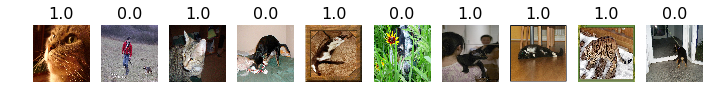

In [28]:
#print(np.round(predictions[:,0]))
#print(test_labels[:,0])
plots(test_imgs[:10], titles=test_labels[:10], rows=1)

In [24]:
cm = confusion_matrix(test_labels, np.round(predictions[1:65,0]))

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_labels = ['cat','dog']

Confusion matrix, without normalization
[[ 7 20]
 [17 20]]


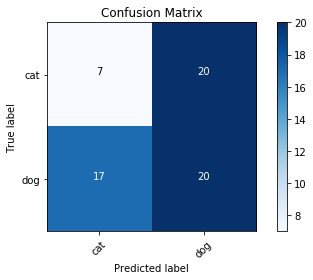

In [26]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')